In [1]:
''' Install necessary libs '''
!pip install matplotlib
!pip install sonopy
!pip install pyaudio
!pip install librosa
!pip install pydub
!sudo apt install sox
!pip install sox
!pip install tqdm
!pip install tensorflow==2.20.0
!pip install keras
#..................import library and module...........................
import tensorflow as tf
import os
from glob import glob
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Lambda, BatchNormalization,LSTM,TimeDistributed,Activation,Dense)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint   
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import os 

  
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import random

from google.colab import drive
import shutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sonopy: filename=sonopy-0.1.2-py3-none-any.whl size=2879 sha256=beaf78a0bf5301448e9b66ff22cd37dce7a0aa49780a538ee31a86025f5fa029
  Stored in directory: /root/.cache/pip/wheels/1f/82/ee/3e858c78c0734f6fe30ade1bd3ef040c7f45eedae6669e88f8
Successfully built sonopy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 KB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pyaudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  

In [2]:
import csv
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/MyDrive/Research_Speech_Recognition/asr_bengali"
list_dir = os.listdir(path)
print(list_dir)
Root_path = path

Mounted at /content/drive
['00b574faaa.flac', 'LICENSE', '00af61420a.flac', '00be8966cf.flac', '00ba8cb4d1.flac', '00b7c616f6.flac', '00b051e227.flac', '00bf0d5a13.flac', '00b32e047d.flac', '00b673bd29.flac', '00b25bf18a.flac', '00b4abede7.flac', '00b0077d19.flac', '00c4df71db.flac', '00bd010e3d.flac', '00b13c83e5.flac', '00b6e012b2.flac', '00bb8ae812.flac', '00b718c37b.flac', '00c2a7235b.flac', '00b7a6990e.flac', '00b9f7554b.flac', '00aebe9d91.flac', '00b5b60f1a.flac', '00c02e30f9.flac', '00b75fc3ec.flac', '00bcfabb00.flac', '00b6759ab3.flac', '00b0c74a8c.flac', '00b95717f6.flac', '00bb2abf2b.flac', '00b5180142.flac', '00af816790.flac', '00c9b2c087.flac', '000c03fe83.flac', '00b5797f0f.flac', '00b49b45bb.flac', '00b1a91838.flac', '00af89f97e.flac', '00bdd8bf21.flac', '00b63139f7.flac', '00c5d597e3.flac', '000af00d30.flac', '00bbf8682d.flac', '00bd5402ad.flac', '00b4f7dd41.flac', '00b49ae437.flac', '00afb09dfd.flac', '00b5f2de82.flac', '00aef1c405.flac', '00b96832dd.flac', '01a8f99bd9.

Scoring functions

The model Class

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_loss = []
test_loss = []
c_err = []
class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

class TransformerEncoder(layers.Layer):
    '''Encode the speech information'''
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TransformerDecoder(layers.Layer):
    '''Decode the speech information'''
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm


class Transformer(keras.Model):
    '''Transform model for speech recognition'''
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    @tf.function
    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        print(source)
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]

        with tf.GradientTape() as tape:
            # take prediciton from the model
            preds = self([source, dec_input])

            # create one-hot and mask to computer loss
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))

            # calculate loss on training data
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # take the all trainable variable the modle
        trainable_vars = self.trainable_variables
        # calculate gradient accordint to loss and trainable variable
        gradients = tape.gradient(loss, trainable_vars)
        
        # update trainable variable accordint to gradient calcualted
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # update loss matric
        self.loss_metric.update_state(loss)
        train_loss.append(self.loss_metric.result())
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        '''Test step perform after each batch finished'''
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]

        # take predictioin from the model
        preds = self([source, dec_input])

        # create one-hot and mask to computer loss
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))

        # computer loss on test sample
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # update loss metric
        self.loss_metric.update_state(loss)
        test_loss.append(self.loss_metric.result())
        return {"loss": self.loss_metric.result()}
    
    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)

        return dec_input


In [5]:
class VectorizeChar:
    def __init__(self, unique_chars, max_len=50):
        self.vocab = (
            [
                "-",
                "#", 
                "<", # use as start token
                ">"  # use as end token
            ]
            + unique_chars
        )
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        '''Make vectorizer as callable object on text
        Args:
            text: str, text sequence
        Returns:
            text sequence represent as number
        '''
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocab(self):
        '''Return all the available vocabulary'''
        return self.vocab

Util Functions for data processing

In [6]:

import random
import os
# character we will filter from text sequence, this can be change according
# to your needs
FILTER_CHARS = [
    '"', '%', "'", ',', '-', '.', '/', '\x93', '\x94', '\u200c', '\u200d', '‘', 
    '’', '“', '”', '…', '!', ':'
]

# english character set to discard
ENGLISH = set([
    '0', '1', '2', '3', '4', '5', 'B', 'L', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 
    'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'z',
])

def clean(text):
    '''Clean text'''
    for c in FILTER_CHARS:
        if c in text:
            text = text.replace(c, '')
    return text


def is_contrain_english_chars(text):
    if ENGLISH.intersection(set(text)):
       return True
    return False


def convert_flac_to_wav(flac_audio_files):
    try:
        print(f"Converting flac to wav")
        for f in tqdm(flac_audio_files):
            cmd = f"sox {f} {f.split('.')[0] + '.wav'}"
            os.system(cmd)
        print('done')
    except Exception as e:
        print(e)


def parse_csv(filename):
    with open(filename, 'r') as file:
        
        
        csv.field_size_limit(2000000)
        reader = csv.reader(file, delimiter='\t')
        headers = next(reader)
        column1 = []
        column2 = []
        for row in reader:
          rand  = random.random()
          if rand < 1.0:#0.70:
            column1.append(row[0])
            column2.append(row[2])
    return column1, column2

def get_data(
    utt_path,
    flac_audio_dir,
    convert = False,
    n_data_to_take=1000,
    max_sequece_to_take=40,
    show_summary=True
):
    _take = 1000
    flac_audio_files = glob(flac_audio_dir + '/*/*.flac')
    if convert:
      print(f"Converting flac to wav")
      for f in tqdm(flac_audio_files):
          cmd = f"sox {f} {f.split('.')[0] + '.wav'}"
          os.system(cmd)
      print('done')
    
    flac_list = [
        os.path.splitext(os.path.basename(_file))[0] 
        for _file in flac_audio_files
    ]
    flac_set = set(flac_list)

    data = []
    unique_chars = set()
    max_text_len = 0
    max_text = ''
    en_bn_mixed = 0
    takes = 0
    lines = parse_csv(utt_path)
    for line in zip(lines[0],lines[1]):
      if os.path.exists(Root_path + "/data/wav_data/" + line[0]+".wav"):
          file_name, text= Root_path + "/data/wav_data/" + line[0]+".wav", line[1] 
          text = clean(text)
          if len(text) > max_sequece_to_take:
              continue
          
          if is_contrain_english_chars(text):
              en_bn_mixed += 1
              continue
          data.append({'audio': file_name, 'text': text})
          for c in text:
              unique_chars.add(c)
          text_len = len(text)
          if max_text_len < text_len:
              max_text_len = text_len
              max_text = text
          
              takes += 1
    unique_chars = sorted(unique_chars)

    if show_summary:
        print(f'flac audio files: {len(flac_audio_files)}')
        print(f'flac_dic        : {len(flac_set)}')
        print(f'utt entry       : {len(lines)}')
        print(f'unique chars    : {len(unique_chars)}')
        print(f'data            : {len(data)}')
        print(f"max text length : {max_text_len}")
        print(f'max text        : {max_text}')
        print(f'en bn mixed     : {en_bn_mixed}')

    return data, unique_chars

def create_lbl_dataset(text_ds):
  return tf.data.Dataset.from_tensor_slices(text_ds)


In [7]:
import os
import shutil

def move_wav_files(dir_list, target_dir):
    # Check if the target directory exists, and create it if it doesn't
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # Iterate through each directory in the list
    for directory in dir_list:
        # Get a list of all the files in the directory
        file_list = os.listdir(directory)
        
        # Iterate through each file in the directory
        for file_name in file_list:
            # Check if the file is a .wav file
            if file_name.endswith('.wav'):
                # Construct the full path to the file
                source_path = os.path.join(directory, file_name)
                
                # Construct the full path to the target directory
                target_path = os.path.join(target_dir, file_name)
                
                # Move the file to the target directory
                shutil.move(source_path, target_path)
# print(len(os.listdir(Root_path+"/data/wav_data")))


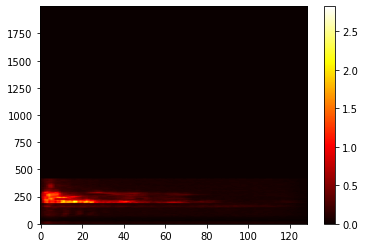

In [8]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def path_to_mfcc(path):

    # spectrogram using stft
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)    

    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256)
    x = tf.math.pow(tf.abs(stfts), 0.5)
    
    audio_len = tf.shape(x)[0]
    
    pad_len = 2000
    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    
    return x

def visualize_mfccs(mfccs):
    plt.imshow(mfccs, origin='lower', aspect='auto', cmap='hot')
    plt.colorbar()
    plt.show()
visualize_mfccs(path_to_mfcc(Root_path+"/data/wav_data/0a5a1687aa.wav"))


In [9]:
# mfccs = []
# labels = []
# vct = VectorizeChar(chars,max_len=40)
# not_found = 0
# data = data[:int(len(data) * 30)]
# for dta in data:
#   try:
#     mfccs.append(path_to_mfcc(dta["mfcc"]))
#     labels.append(vct(dta["text"]))

#   except:
#     not_found += 1
# split = int(len(mfccs) * 0.70)
# t_mfccs = tf.data.Dataset.from_tensor_slices(mfccs[split:])
# t_labels = tf.data.Dataset.from_tensor_slices(labels[split:])
# mfccs = tf.data.Dataset.from_tensor_slices(mfccs)
# labels = tf.data.Dataset.from_tensor_slices(labels)
def create_text_ds(data, vectorizer):
    '''Create text Dataset using vectorizer
    
    Args:
        data: list of dictionary in mfcc: text format
        vectorizer: VectorizeChar object to convert text 
                    sequence to it's vector representation
    
    Returns:
        Tensorflwo Dataset object
    '''
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    
    return text_ds

def create_mfcc_ds(data):

    flist = [_["audio"] for _ in data]
    mfcc_ds = tf.data.Dataset.from_tensor_slices(flist)
    mfcc_ds = mfcc_ds.map(
        path_to_mfcc, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    return mfcc_ds


def create_tf_dataset(data, vectorizer, bs=4):

    mfcc_ds = create_mfcc_ds(data)
    text_ds = create_text_ds(data, vectorizer)

    ds = tf.data.Dataset.zip((mfcc_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [13]:
seed = 777
tf.random.set_seed(seed)


class DisplayOutputs(keras.callbacks.Callback):
    '''Display model outut after each specefied epochs'''
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):
        """Displays a batch of outputs after every epoch
        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 != 0:
            return
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")


Training Loop

In [11]:
data, unique_chars = get_data(
    Root_path+"/utt_spk_text.tsv",
    Root_path+"/data"
)

max_target_len = 40 
vectorizer = VectorizeChar(unique_chars, max_target_len)
print("vocab size", len(vectorizer.get_vocab()))

# split data into train validation
data = data
split = int(len(data) * 0.70)
train_data = data # data[:split]
test_data = data[split:]

flac audio files: 12908
flac_dic        : 12908
utt entry       : 2
unique chars    : 73
data            : 8721
max text length : 40
max text        : ১৯৬৪ সালে অকল্যান্ড প্রযুক্তি ইন্সটিটিউট
en bn mixed     : 3
vocab size 77


In [19]:
vectorizer("১৯৬৪ সালে অকল্যান্ড প্রযুক্তি ")

[2,
 68,
 76,
 73,
 71,
 4,
 50,
 53,
 47,
 59,
 4,
 9,
 20,
 47,
 63,
 45,
 53,
 39,
 63,
 32,
 4,
 40,
 63,
 46,
 45,
 56,
 20,
 63,
 35,
 54,
 4,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [21]:


class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate

  def __call__(self, step):
     return self.initial_learning_rate / (step + 1)


with tf.device('/GPU:0'):
  ds = create_tf_dataset(train_data, vectorizer, bs=8)
  val_ds = create_tf_dataset(test_data, vectorizer, bs=4)
  print("train data", len(train_data))
  print("test data",len(test_data))
  # take test sample
  batch = next(iter(val_ds))

  # The vocabulary to convert predicted indices into characters
  idx_to_char = vectorizer.get_vocab()
  display_cb = DisplayOutputs(
      batch, idx_to_char, target_start_token_idx=2, target_end_token_idx=3
  )  # set the arguments as per vocabulary index for '<' and '>'

  # init transformer model
  model = Transformer(
      num_hid=200,
      num_head=2,
      num_feed_forward=400,
      target_maxlen=max_target_len,
      num_layers_enc=4,
      num_layers_dec=1,
      num_classes=len(vectorizer.get_vocab()), #108 -> number of vocab in vectorizer
  )

  # define loss matric. label_smoothing is important because 
  # class distribution is not equal
  loss_fn = tf.keras.losses.CategoricalCrossentropy(
      from_logits=True, label_smoothing=0.1,
  )

  # learning reate scheduler


  # model checpoint saving callbacks
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
      filepath="./model.pb", 
      save_weights_only=True,
      verbose=0
  )

  optimizer = keras.optimizers.Adam(learning_rate=0.0001,jit_compile=True)

  # compile the model
  model.compile(optimizer=optimizer, loss=loss_fn)

# resueme already trained model


# start training the model
with tf.device('/GPU:0'):
  model.fit(
    ds,
    validation_data=val_ds,
    callbacks=[display_cb, checkpoint_cb],
    initial_epoch=0,
      epochs=24
  )

train data 8721
test data 2617
Epoch 1/24
Tensor("batch:0", shape=(None, None, 129), dtype=float32)
Tensor("batch:0", shape=(None, None, 129), dtype=float32)
1091/1091 [==============================] - ETA: 0s - loss: 1.5617target:     <লক্ষ্যভেদ করেন বেল>
prediction: <তার কর করানার কা>

target:     <বেশ কয়েকজন>
prediction: <তার করের কা>

target:     <অন্যান্য সুবিধা বৃদ্ধি করা হবে>
prediction: <বিন্র পর কর কর্য়ে>

target:     <বাংলাদেশে নির্বাচনের বাকী>
prediction: <বিন্র পর করারার কর>

1091/1091 [==============================] - 140s 111ms/step - loss: 1.5617 - val_loss: 1.4541
Epoch 2/24
1091/1091 [==============================] - 118s 109ms/step - loss: 1.4676 - val_loss: 1.4129
Epoch 3/24
1091/1091 [==============================] - 117s 108ms/step - loss: 1.4113 - val_loss: 1.3374
Epoch 4/24
1091/1091 [==============================] - 117s 107ms/step - loss: 1.3362 - val_loss: 1.2457
Epoch 5/24
1091/1091 [==============================] - 118s 108ms/step - loss: 1.2496 - va

In [23]:
%cd /content/drive/MyDrive
%cp /content/model.pb.data-00000-of-00001 speech_reg
%cp /content/model.pb.index speech_reg
%cp /content/checkpoint speech_reg

/content/drive/MyDrive


In [32]:
model.evaluate()

ValueError: ignored